In [17]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../../NIPMAP(Requierd_Packages)/')) # NIPMAP package
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/razi.m/Bs_Molecular_Bioinformatics/Year3/Spring_Semester_2023/Thesis/NIPMAP_on_HIFI_data/HIFI_analysis/notebooks'

### Import requierments packages, NIPMAP packages can be found in src folder.

In [18]:
import pandas as pd
import numpy as np
import json
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from src.CellAbundance import CellAbundance, join_abundance_matrices, generate_abundance_matrix
from src.utils.archetypes import ArchetypalAnalysis
from src.utils.equations import compute_cells_niches_weights,get_niches_cell_abund
from src.utils.visualization import plot_cells_positions,radius_pc_all_variance
from sklearn.decomposition import PCA

### Define the data path and requirements parameter. 

In [19]:
CELLTYPES = ['Astrocyte', 'Fibroblast', 'Neuron', 'Neutrophil', 'OPC-like','T-cell', 'TAM', 'Tumor_A','Tumor_B','Vessel','Undefined']

ImageIDs =  ["31801_32Un","31803_13Tr", "33876_36Re"] 

RADIUS = 25 
METHOD ="gaussian"

# the x and y value can be find in r script(maximum of x and y in the rectangle of the image ) 

XSIZE = {"31801_32Un": 3300,"31803_13Tr": 3100,"33876_36Re": 4400}
YSIZE = {"31801_32Un": 2800,"31803_13Tr": 1450,"33876_36Re": 2400}

NSITES = {"31801_32Un": 4700,"31803_13Tr":2290,"33876_36Re": 5378}

Data_Path = "../data"   
Output_path= "../output"
Fig_path = "../output/fig"

Imageinfo = "UnTrRe" 


### Generate random sampling sites and cell aboundance 


In [20]:

RADIUS = int(input('Enter Radius for sampling sites(in micrometers/should be int):\n'))  
    
CeAbLi = generate_abundance_matrix(CELLTYPES, ImageIDs, NSITES,RADIUS,method=METHOD,
                                  random_seed=1022,snr=3,center_sites_cells=False,
                                   root=Data_Path)

sites, patients_ids,sites_ids, _ = join_abundance_matrices(CeAbLi)


print("Generating sites with cell abundance...")

#create a data frame from the output of the abundance matrix

CeAbDf = pd.DataFrame()
for i in CeAbLi:
    df_Ab = pd.DataFrame(i.abundance_matrix,columns = CELLTYPES)
    df_Ab['site_id'] = np.arange(len(df_Ab))
    df_Ab['patient_id'] = i.patient_id
    CeAbDf = CeAbDf.append(df_Ab)

CeAbDf = CeAbDf.reset_index()
CeAbDf

#create a dictionary of cell abundance of randomly generated sites
CeAbSiDi = {"cellAbSites": CeAbDf.to_dict()}

# Serializing json objects
CeAbSi_json = json.dumps(CeAbSiDi,indent=4) # cell abundance of randomly generated sites

print("save cell abundance of randomly generated sites as a json file... ")

# Writing to .json files to be later use in r 
with open(Output_path+ "/CeAbSi_%s.json" %(Imageinfo),"w") as f1:
    f1.write(CeAbSi_json)


Enter Radius for sampling sites(in micrometers/should be int):
25
Generating sites with cell abundance...
save cell abundance of randomly generated sites as a json file... 


### PCA on sites abundance 


In [21]:
print("Dimension reduction of sites cell abundances...")
PcOb = PCA()
PcSi = PcOb.fit_transform(sites)
PcSi 

#create a dictionary of PCA summary
PcDi = {"PcSi":PcSi.tolist(),
        "components":PcOb.components_.tolist(),
        "expl_variance":PcOb.explained_variance_.tolist(),
        "expl_var_ratio":PcOb.explained_variance_ratio_.tolist(),
        "mean":PcOb.mean_.tolist()}


print("save PCA analysis as a json file... ")

# Serializing json objects
PCA_json = json.dumps(PcDi, indent=4) # PCA

# Writing to .json files to be later use in r 

with open(Output_path+"/pca_sites_%s.json" %(Imageinfo), "w") as f2:
    f2.write(PCA_json)

Dimension reduction of sites cell abundances...
save PCA analysis as a json file... 


### To use the same colors for visualization in R, define the color based on the number of niches, convert RGB color to hex color, and save the file as a json.

In [22]:
#COLARCHS =[(255,0,223),(70,203,236),(247,221,25),(8, 94, 4)] # 4 niches
#COLARCHS = [(255,0,223),(13, 189, 60),(70,203,236),(240, 158, 17),(0,0,0)] # 5 niches
#COLARCHS = [(255,0,223),(240, 17, 35),(70,203,236),(240, 158, 17),(13, 189, 60),(0,0,0)] # 6 niches
#COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(0,0,0)] # 7 niches
#COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(192, 214, 21),(0,0,0)] # 8 niches
#COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(192, 214, 21),(168, 50, 168),(0,0,0)] # 9 niches
#COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(192, 214, 21),(168, 50, 168),(237, 138, 159),(0,0,0)] # 10 niches
COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(192, 214, 21),(168, 50, 168),(237, 138, 159),(186, 247, 212),(0,0,0)] # 11 niches
#COLARCHS = [(255,0,223),(70,203,236),(240, 17, 35),(240, 158, 17),(13, 189, 60),(108, 115, 196),(192, 214, 21),(168, 50, 168),(237, 138, 159),(186, 247, 212),(5, 169, 181),(0,0,0)] # 12 niches


NiCo = [] # empty list for niche color

# get each item of color list and convert it to hex color
def RGB_HEX(ColorList):
    for i in ColorList: 
        x= '#%02x%02x%02x' % i
        NiCo.append(x)
    return (NiCo)

RGB_HEX(COLARCHS)

print("save hex colors as a json file... ")

NiCo ={"Niche_color": NiCo} # create a dictionary of the hex color 

# Serializing json objects
NiCo_json = json.dumps(NiCo,indent=4 )# Niches color code 

# Writing to .json files to be later use in r 
with open(Output_path+ "/niches_color_%s.json" %(Imageinfo),"w") as f3:
    f3.write(NiCo_json)


save hex colors as a json file... 


### Archetype analysis
#### Archetype analysis was done based on the chosen archetype and by using the "get_niches_cell_abund" function to generate niche cell abundance. To plot the cell abundance in each niche, a data frame of the output was created.

In [23]:
print("Finding niches...")
NoNi = 11
ncomp= NoNi-1
ArAn = ArchetypalAnalysis(n_archetypes =NoNi,
                 tolerance = 0.001,
                 max_iter = 200,
                 random_state = 0,
                 C = 0.0001,
                 initialize = 'random',
                 redundancy_try = 30)
ArAn.fit_transform(PcSi[:,:ncomp])



print(str(NoNi)+" niches found!")

NiCePro=get_niches_cell_abund(sitesCellAb=sites,pcaSites=PcOb,ArchObj=ArAn,nComp=ncomp)

#create a dictionary of Archytype analysis and nich cell abundance 
ArDi = {"archs_coord": ArAn.archetypes.tolist(),
        "alfas": ArAn.alfa.tolist(),
        "nichesCA":NiCePro.tolist()}

# Serializing json objects
ArAn_json = json.dumps(ArDi, indent=4) # Archytype analysis 

print("save Archetype analysis and niche cell abundance as a json file... ")

# Writing to .json files to be later use in r 
with open(Output_path+ "/ArAn_sites_%s.json" %(Imageinfo),"w") as f4:
    f4.write(ArAn_json)



# add celltype as columnn name
NiCeProDf = pd.DataFrame(NiCePro, columns = CELLTYPES ,
                                      index=['Niche1', 'Niche2', 'Niche3','Niche4','Niche5','Niche6','Niche7',
                                             'Niche8','Niche9','Niche10','Niche11'])
NiCeProDf




Finding niches...
11 niches found!
save Archetype analysis and niche cell abundance as a json file... 


Astrocyte    Fibroblast        Neuron    Neutrophil      OPC-like  \
Niche1    0.011796  1.469353e-06  5.165003e-05  8.513614e-09  8.164475e-08   
Niche2    0.000432  8.318068e-04 -1.204008e-07 -3.153610e-07 -3.024282e-06   
Niche3    0.000368  6.709695e-05  5.480929e-08  4.618480e-04  1.376725e-06   
Niche4    0.001188  5.693331e-07  1.259435e-09  3.298788e-09  3.163506e-08   
Niche5    0.000526  1.621724e-05  8.920608e-04  9.396473e-08  3.996725e-03   
Niche6    0.004969 -7.652884e-07  6.311350e-04 -4.434178e-09 -4.252334e-08   
Niche7    0.000337  7.446807e-05  3.948866e-03 -7.067034e-08 -6.777219e-07   
Niche8    0.000701 -9.516074e-06  9.057594e-04  6.418865e-04 -5.287618e-07   
Niche9    0.000845  4.803681e-06  1.062633e-08  2.783313e-08  1.882176e-04   
Niche10   0.000447  1.918171e-06  1.561072e-03  1.998543e-03  1.261240e-04   
Niche11   0.000081  1.387115e-06  9.032754e-05  8.037119e-09  7.707521e-08   

               T-cell           TAM       Tumor_A   Tumor_B    Vessel  \
Niche1  -3.582600e-08  8.688313e-05  4.606777e-04 -0.000004  0.000344   
Niche2   1.732374e-02  1.558374e-03  3.935487e-08  0.000135  0.000316   
Niche3   1.079231e-02  6.213041e-04 -1.791527e-08 -0.000062  0.004315   
Niche4  -1.388158e-08  4.759711e-04  5.367742e-03 -0.000001  0.000832   
Niche5   5.967362e-07  3.335768e-04  1.271852e-03  0.000092  0.000431   
Niche6   7.503483e-05  1.001735e-03  5.118332e-03  0.000002  0.002115   
Niche7   1.415550e-04  1.657339e-04  9.092003e-05  0.000030  0.000421   
Niche8   2.589612e-04  6.752725e-04  3.396719e-04  0.000024  0.003724   
Niche9   3.524686e-04  2.017933e-03  3.022531e-05 -0.000012  0.000666   
Niche10  8.151750e-04  6.975995e-04  2.345763e-04 -0.000005  0.000515   
Niche11 -3.382087e-08 -2.604497e-08 -1.002977e-09 -0.000003  0.000067   

            Undefined  
Niche1   7.665262e-04  
Niche2   1.155325e-03  
Niche3   1.273744e-03  
Niche4   6.158438e-05  
Niche5   1.423765e-04  
Niche6   6.096710e-04  
Niche7   6.566699e-06  
Niche8   3.305241e-07  
Niche9   1.310497e-04  
Niche10  1.242246e-04  
Niche11 -4.817900e-08

### bar plot of niche cell composition, colored by cell type

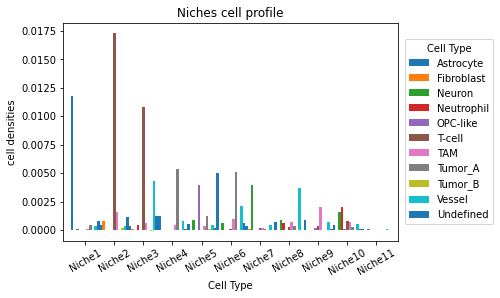

In [24]:
NiCeProDf.plot.bar( title = "Niches cell profile", subplots=False,
           xlabel="Cell Type",ylabel= "cell densities", width=1)
plt.xticks(rotation=30, horizontalalignment="center")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0,
           title='Cell Type').get_figure().savefig(Fig_path+ "/NichCellProfile_celltype_%s.png" %(Imageinfo),
            dpi=300, bbox_inches='tight')

### bar plot of niche cell composition, colored by niches 

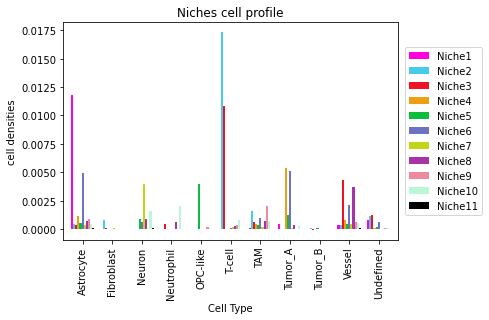

In [25]:
# divide RGB color (COLARCHS) to 255, because plot.bar() in panda package accepts the range between 0 to 1 to specify a color.
Ar_col = []
for i in COLARCHS :
    item = []
    for b in i:
        item.append(b/255)
    Ar_col.append(item)
       
    
pl = NiCeProDf.transpose()

pl.plot.bar(color = Ar_col, title = "Niches cell profile",width=0.8, subplots=False,xlabel="Cell Type",
            ylabel= "cell densities")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0).get_figure().savefig(Fig_path+ "/NichCellProfile_%s.png" %(Imageinfo), 
            dpi=300,bbox_inches='tight')


### Segmenting images into niches and save as svg file

 The computational time for Segmenting images into niches is long... 


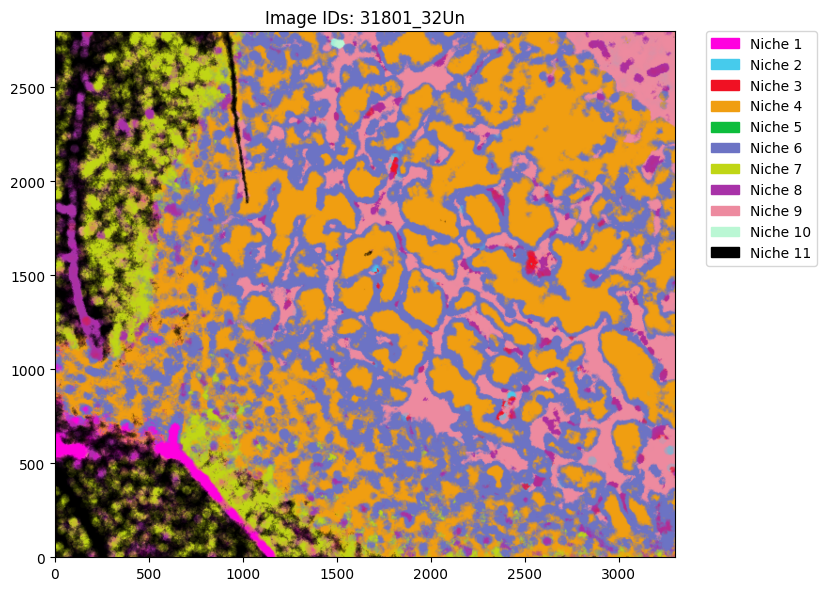

In [15]:
print(" The computational time for Segmenting images into niches is long... ")
XSIZE = 3300 
YSIZE = 2800
ImageIDs =  ["31801_32Un"] 
for i in ImageIDs:
    GRANULARITY = 5
    CePo = pd.read_csv(Data_Path+"/patient{}_cell_positions.csv".format(i))
    plot_cells_positions(CePo ,ImageIDs, CELLTYPES, segment_image=True, counting_type=METHOD,
                         color_vector=COLARCHS,segmentation_type='colors',
                         granularity=GRANULARITY, radius=RADIUS,pca_obj=PcOb,
                         AA_obj=ArAn, to_plot = 'None',h=YSIZE, w=XSIZE,
                        path_fig= Fig_path+ "/nichesSeg_patient{}.svg".format(i))

 The computational time for Segmenting images into niches is long... 


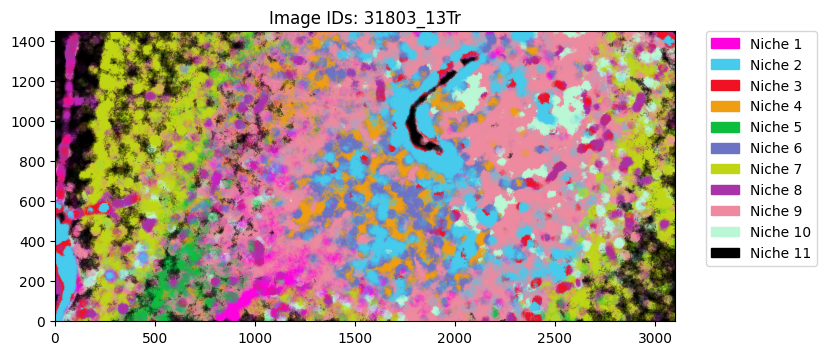

In [16]:

print(" The computational time for Segmenting images into niches is long... ")
XSIZE = 3100
YSIZE = 1450

ImageIDs =  ["31803_13Tr"] 

for i in ImageIDs:
    GRANULARITY = 5
    CePo = pd.read_csv(Data_Path+"/patient{}_cell_positions.csv".format(i))
    plot_cells_positions(CePo ,ImageIDs, CELLTYPES, segment_image=True, counting_type=METHOD,
                         color_vector=COLARCHS,segmentation_type='colors',
                         granularity=GRANULARITY, radius=RADIUS,pca_obj=PcOb,
                         AA_obj=ArAn, to_plot = 'None',h=YSIZE, w=XSIZE,
                        path_fig= Fig_path+ "/nichesSeg_patient{}.svg".format(i))

 The computational time for Segmenting images into niches is long... 


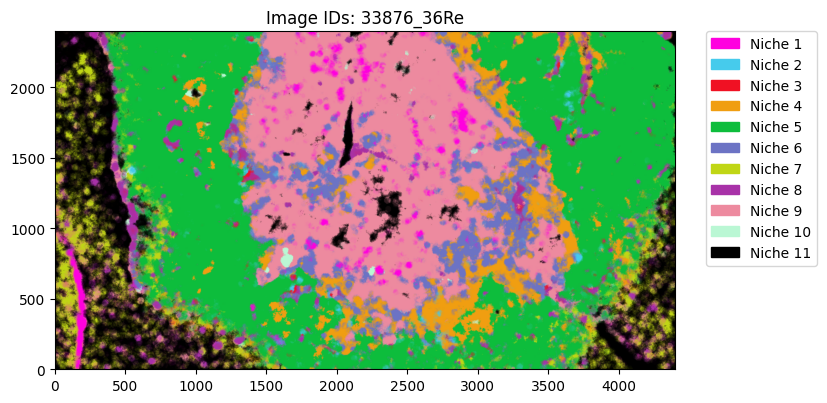

In [17]:

print(" The computational time for Segmenting images into niches is long... ")
XSIZE = 4400
YSIZE = 2400
ImageIDs =  ["33876_36Re"] 

for i in ImageIDs:
    GRANULARITY = 5
    CePo = pd.read_csv(Data_Path+"/patient{}_cell_positions.csv".format(i))
    plot_cells_positions(CePo ,ImageIDs, CELLTYPES, segment_image=True, counting_type=METHOD,
                         color_vector=COLARCHS,segmentation_type='colors',
                         granularity=GRANULARITY, radius=RADIUS,pca_obj=PcOb,
                         AA_obj=ArAn, to_plot = 'None',h=YSIZE, w=XSIZE,
                        path_fig= Fig_path+ "/nichesSeg_patient{}.svg".format(i))

### Niche environments of cells
#### In this process, sites’ centers were no longer defined randomly but rather the sites were created in a way that each site has a cell as its central focus by setting the "center_sites_cells" to True

In [26]:
print("Computing cells' niches weights, the operation might take some time for more that one image...")

ImageIDs =  ["31801_32Un","31803_13Tr", "33876_36Re"] 
XSIZE = {"31801_32Un": 3300,"31803_13Tr": 3100,"33876_36Re": 4400}
YSIZE = {"31801_32Un": 2800,"31803_13Tr": 1450,"33876_36Re": 2400}

NSITES = {"31801_32Un": 4700,"31803_13Tr":2290,"33876_36Re": 5378}

CeAbCnCeli = generate_abundance_matrix(CELLTYPES, ImageIDs, NSITES,RADIUS,
                                       method=METHOD, snr=3,center_sites_cells=True,
                                       border=False,root=Data_Path)
sitesCC, patients_ids2,sites_ids2, _ = join_abundance_matrices(CeAbCnCeli)

# by using quadratic programming niches weights was calculated
CeNiWgt = compute_cells_niches_weights(niches=NiCePro,cellsSites=sitesCC,nbNiches=NoNi)

SiAr = pd.DataFrame(CeNiWgt)
SiAr['SampleID'] = patients_ids2
SiAr["cell_id"] = sites_ids2[:,0]
SiAr["cell_type"] = sites_ids2[:,1]
SiAr["TOT_cell_dens"]= sitesCC.sum(axis=1)
SiAr.to_csv(Output_path + "/sites_cells_archs_%s.csv" %(Imageinfo),index=False)

#create a dictionary of sites centered on cells and niches weights
CeAbSiCnCeDi = {"cells_niches": SiAr.to_dict()}

# Serializing json objects
CeNiWgt_json = json.dumps(CeAbSiCnCeDi,indent=4) # sites centered on cells and niches weights

print("save cells' niches weights as a json file... ")

# Writing to .json files to be later use in r 
with open(Output_path + "/cells_niches_%s.json" %(Imageinfo),"w") as f5:
    f5.write(CeNiWgt_json)

    
df = pd.read_csv (Output_path + "/sites_cells_archs_%s.csv" %(Imageinfo))
df

Computing cells' niches weights, the operation might take some time for more that one image...
save cells' niches weights as a json file... 


0             1             2             3             4  \
0     2.441952e-02  0.000000e+00  2.592217e-18 -2.444204e-18 -3.571074e-19   
1     1.928973e-02  0.000000e+00  2.673858e-18 -2.495514e-18 -3.679952e-19   
2     2.393548e-02  0.000000e+00  2.576671e-18 -2.386720e-18 -3.539336e-19   
3     3.412524e-02  0.000000e+00  2.378927e-18 -2.234673e-18 -3.273383e-19   
4     2.587206e-02  0.000000e+00  2.417888e-18 -2.163430e-18 -1.336098e-18   
...            ...           ...           ...           ...           ...   
7210 -5.400926e-18  2.496261e-17  0.000000e+00 -5.009586e-17  6.956536e-01   
7211 -1.524050e-18  7.047648e-18  0.000000e+00  5.730395e-18  7.659612e-01   
7212 -2.155415e-18 -1.551605e-19 -4.699280e-20 -9.629650e-34  6.693237e-01   
7213  7.266235e-20  1.742251e-17  0.000000e+00  1.465036e-17  7.261032e-01   
7214 -2.564626e-18  5.595811e-19  0.000000e+00  2.233220e-18  5.764828e-01   

                 5         6             7             8             9  \
0    -1.423186e-16  0.538100  4.025055e-17  1.748609e-02  9.792265e-18   
1    -1.436959e-16  0.544117  3.941098e-17  2.274620e-02  1.008555e-17   
2    -1.340358e-16  0.524705  3.604483e-17  2.024288e-02  9.700743e-18   
3    -1.252943e-16  0.487261  3.564374e-17  1.664825e-02  8.987400e-18   
4    -1.386014e-16  0.468871  2.660388e-17  2.574782e-02  4.926479e-18   
...            ...       ...           ...           ...           ...   
7210  5.480315e-02  0.044378  2.051651e-01  1.432338e-16 -7.152581e-18   
7211  3.152897e-16  0.112878  1.211609e-01  6.492655e-17  1.012097e-16   
7212 -2.957869e-18  0.330676  0.000000e+00 -7.708170e-19  6.618739e-18   
7213  3.658593e-16  0.250929  2.296790e-02  5.914907e-17  1.073454e-16   
7214  3.583855e-16  0.409991  1.007003e-02 -5.455923e-18  0.000000e+00   

                10    SampleID  cell_id  cell_type  TOT_cell_dens  
0     4.199942e-01  31801_32Un   128598     Neuron       0.002969  
1     4.138468e-01  31801_32Un   128600     Neuron       0.002954  
2     4.311169e-01  31801_32Un   128601     Neuron       0.002923  
3     4.619654e-01  31801_32Un   128602     Neuron       0.002863  
4     4.795093e-01  31801_32Un   128606  Astrocyte       0.002733  
...            ...         ...      ...        ...            ...  
7210  1.654999e-15  33876_36Re    50721     Vessel       0.010378  
7211  1.289199e-18  33876_36Re    50722    Tumor_A       0.006645  
7212  7.265408e-16  33876_36Re    50723        TAM       0.006657  
7213 -5.434145e-18  33876_36Re    50724     Neuron       0.006584  
7214  3.456295e-03  33876_36Re    50725     Neuron       0.005939  

[7215 rows x 15 columns]

In [27]:
CeNiWe_all_groups = pd.DataFrame()
#CeNiWe_all_groups['Total_cell'] = df['SampleID'].value_counts()
CeNiWe_all_groups['Niche 1'] = df.groupby('SampleID')['0'].mean()
CeNiWe_all_groups['Niche 2'] = df.groupby('SampleID')['1'].mean()
CeNiWe_all_groups['Niche 3'] = df.groupby('SampleID')['2'].mean()
CeNiWe_all_groups['Niche 4'] = df.groupby('SampleID')['3'].mean()
CeNiWe_all_groups['Niche 5'] = df.groupby('SampleID')['4'].mean()
CeNiWe_all_groups['Niche 6'] = df.groupby('SampleID')['5'].mean()
CeNiWe_all_groups['Niche 7'] = df.groupby('SampleID')['6'].mean()
CeNiWe_all_groups['Niche 8'] = df.groupby('SampleID')['7'].mean()
CeNiWe_all_groups['Niche 9'] = df.groupby('SampleID')['8'].mean()
CeNiWe_all_groups['Niche 10'] = df.groupby('SampleID')['9'].mean()
CeNiWe_all_groups['Niche 11'] = df.groupby('SampleID')['10'].mean()

CeNiWe_all_groups

Niche 1   Niche 2   Niche 3   Niche 4   Niche 5   Niche 6  \
SampleID                                                                 
31801_32Un  0.186201  0.000009  0.000574  0.127929  0.000006  0.048873   
31803_13Tr  0.023356  0.062346  0.065567  0.024538  0.099701  0.002635   
33876_36Re  0.113658  0.000237  0.000295  0.019142  0.103025  0.002952   

             Niche 7   Niche 8   Niche 9      Niche 10  Niche 11  
SampleID                                                          
31801_32Un  0.186897  0.066688  0.024888 -1.559300e-18  0.357936  
31803_13Tr  0.250228  0.081654  0.177164  8.972793e-02  0.123084  
33876_36Re  0.278291  0.074169  0.052840  5.128654e-03  0.350262

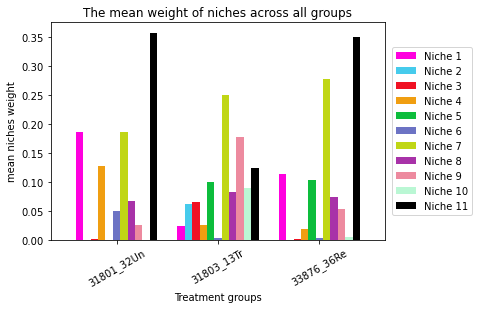

In [28]:

CeNiWe_all_groups.plot.bar(color = Ar_col, title = "The mean weight of niches across all groups",width=0.8,
            subplots=False,xlabel="Treatment groups",ylabel= "mean niches weight")
plt.xticks(rotation=30, horizontalalignment="center")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left',
           borderaxespad=0).get_figure().savefig(Fig_path+ "/nicheweights_all groups_%s.png" %(Imageinfo), 
           dpi=300,bbox_inches='tight')

In [29]:

pio.templates.default = "plotly_white"

fig = go.Figure ()
fig.add_trace(go.Bar(name = "Niche 1", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 1'], text= CeNiWe_all_groups['Niche 1'].round(2),marker=dict(color='rgb(255,0,223)',line=dict(color='rgb(255,0,223)', width=1))))
fig.add_trace(go.Bar(name = "Niche 2", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 2'], text= CeNiWe_all_groups['Niche 2'].round(2),marker=dict(color='rgb(70,203,236)',line=dict(color='rgb(70,203,236)', width=1))))
fig.add_trace(go.Bar(name = "Niche 3", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 3'], text= CeNiWe_all_groups['Niche 3'].round(2),marker=dict(color='rgb(240, 17, 35)',line=dict(color='rgb(240, 17, 35)', width=1))))
fig.add_trace(go.Bar(name = "Niche 4", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 4'], text= CeNiWe_all_groups['Niche 4'].round(2),marker=dict(color='rgb(240, 158, 17)',line=dict(color='rgb(240, 158, 17)', width=1))))
fig.add_trace(go.Bar(name = "Niche 5", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 5'], text= CeNiWe_all_groups['Niche 5'].round(2),marker=dict(color='rgb(13, 189, 60)',line=dict(color='rgb(13, 189, 60)', width=1))))
fig.add_trace(go.Bar(name = "Niche 6", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 6'], text= CeNiWe_all_groups['Niche 6'].round(2),marker=dict(color='rgb(108, 115, 196)',line=dict(color='rgb(108, 115, 196)', width=1))))
fig.add_trace(go.Bar(name = "Niche 7", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 7'], text= CeNiWe_all_groups['Niche 7'].round(2),marker=dict(color='rgb(192, 214, 21)',line=dict(color='rgb(192, 214, 21)', width=1))))
fig.add_trace(go.Bar(name = "Niche 8", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 8'], text= CeNiWe_all_groups['Niche 8'].round(2),marker=dict(color='rgb(168, 50, 168)',line=dict(color='rgb(168, 50, 168)', width=1))))
fig.add_trace(go.Bar(name = "Niche 9", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 9'], text= CeNiWe_all_groups['Niche 9'].round(2),marker=dict(color='rgb(237, 138, 159)',line=dict(color='rgb(237, 138, 159)', width=1))))
fig.add_trace(go.Bar(name = "Niche 10", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 10'], text= CeNiWe_all_groups['Niche 10'].round(2),marker=dict(color='rgb(186, 247, 212)',line=dict(color='rgb(186, 247, 212)', width=1))))
fig.add_trace(go.Bar(name = "Niche 11", x=CeNiWe_all_groups.index, y= CeNiWe_all_groups['Niche 11'], text= CeNiWe_all_groups['Niche 11'].round(2),marker=dict(color='rgb(0,0,0)',line=dict(color='rgb(0,0,0)', width=1))))
fig.update_traces(textposition='outside')
fig.update_layout(title_text=" Mean weight of niches across Treatment groups" , xaxis_title="Treatment groups", yaxis_title= "Mean niches weight")
fig.show()

fig.write_html(Fig_path+"/nicheweights_all groups_%s.html"%(Imageinfo))

In [30]:
# to determine which cell type was eliminated from the sample site due to a small proportion
s_arch = pd.DataFrame(CeNiWgt)
s_arch["cell_type"] = sites_ids2[:,1]

print(s_arch["cell_type"].unique())

['Neuron' 'Astrocyte' 'Vessel' 'TAM' 'Tumor_A' 'Undefined' 'T-cell'
 'OPC-like' 'Neutrophil' 'Fibroblast' 'Tumor_B']
